# Importing the libraries required for the training

In [3]:
# common imports
import zipfile
import pandas as pd
import numpy as np
import time
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
# import datetime, timedelta
import datetime
import pydotplus
from datetime import datetime, timedelta
from datetime import date
from dateutil import relativedelta
from io import StringIO
import pandas as pd
import pickle
from pickle import dump
from pickle import load
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
# DSX code to import uploaded documents
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import os
import yaml
import math
import sys
from subprocess import check_output
from IPython.display import display
#model libraries
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
#from tf.keras.layers.normalization import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
# from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.python.keras.callbacks import TensorBoard
#import datetime
#from datetime import date
from sklearn import metrics
# import pipeline libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from custom_classes import encode_categorical
from custom_classes import prep_for_keras_input
from custom_classes import fill_empty
from custom_classes import encode_text


In [4]:
import tensorflow as tf
tf.__version__ 

'2.1.0'

In [6]:
current_path = os.getcwd()
print("current directory is: "+current_path)

current directory is: C:\Users\mshaf\MachineLearningTTC\notebooks


In [7]:
# load parameters

repeatable_run = False 
# fix seeds to get identical results on mulitiple runs
if repeatable_run:
    from numpy.random import seed
    seed(4)
    tf.random.set_seed(7)


testproportion = 0.3
trainproportion = 0.7
get_test_train_acc = True 
verboseout = True 
includetext = True  #switch to determine whether text columns are included in the model
save_model_plot = False #switch to determine whether to generate plot with plot_model
tensorboard_callback = False #switch to determine if tensorboard callback defined

presaved = False
savemodel = False
picklemodel = True 
hctextmax = 7000
maxwords = 6000
textmax = 50

targetthresh = 10 # use as boundary between delay and no delay
targetcontinuous = False # switch to determine whether target is continuous

#time of day thresholds
time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':24}}



emptythresh = 6000
zero_weight = 1.0 # class_weight = {0 : zero_weight, 1: one_weight}
one_weight = 45.878 # default one_weight
one_weight_offset = 0 # additional offset to one_weight
patience_threshold = 15


# modifier for saved model elements
modifier = "ML_Project" #config['general']['modifier']

# control whether training controlled by early stop
early_stop = True

# default hyperparameter values
learning_rate = 0.001
dropout_rate = 0.005
l2_lambda = 0.005
loss_func = "binary_crossentropy"
output_activation = "hard_sigmoid"
batch_size = 4096 # in the power of 2
epochs = 100

# date values
date_today = datetime.now()
print("date today",date_today)
start_date =  date(2014,1,1)
print("start date",start_date)
end_date = date(2020,8,3) #3rd August, 2020
print("end date",end_date)


# pickled original dataset and post-preprocessing dataset
#pickled_data_file = config['general']['pickled_data_file']
pickled_dataframe = 'cleaned_Data.pkl' #config['general']['pickled_dataframe']
routedirection_file = 'routedirection.csv'#config['general']['route_direction_file']

# experiment parameter

current_experiment = 5

date today 2021-05-10 23:42:23.315095
start date 2014-01-01
end date 2020-08-03


# Helper functions

In [5]:
# time_of_day = {'overnight':{'start':0,'end':5},'morning_rush':{'start':5,'end':10},
#              'midday':{'start':10,'end':15},'aft_rush':{'start':15,'end':19},'evening':{'start':19,'end':23}}


def get_time(hour):
    for tod in time_of_day:
        if (hour >= time_of_day[tod]['start']) and (hour < time_of_day[tod]['end']):
            tod_out = tod
    return(tod_out)

def weekend_time(day, tod):
    if (day=='Saturday') or (day=='Sunday'):
        return('w'+tod)
    else:
        return(tod)

# get the paths required

def get_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'data'))
    return(path)

def get_pipeline_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'pipelines'))
    return(path)

def get_model_path():
    '''get the path for data files'''
    rawpath = os.getcwd()
    # data is in a directory called "data" that is a sibling to the directory containing the notebook
    path = os.path.abspath(os.path.join(rawpath, '..', 'models'))
    return(path)

def set_experiment_parameters(experiment_number, count_no_delay, count_delay):
    ''' set the appropriate parameters for the experiment '''
    print("setting parameters for experiment ", experiment_number)
    # default settings for early stopping:
    es_monitor = "val_loss"
    es_mode = "min"
    if experiment_number == 5:
        #
        early_stop = True
        # if early stopping fails because the level of TensorFlow/Python, comment out the following
        # line and uncomment the subsequent if statement
        es_monitor="val_accuracy" 
        es_mode = "max"
        #
        one_weight = (count_no_delay/count_delay) + one_weight_offset
        #
        epoch = 50
    else:
        early_stop = True
    return(early_stop, one_weight, epochs,es_monitor,es_mode)

# load list of valid routes and directions into dataframe
def ingest_data(path):
    routedirection_frame = pd.read_csv(os.path.join(path,routedirection_file))
    routedirection_frame.tail()
    file_name = os.path.join(path,pickled_dataframe)
    merged_data = pd.read_pickle(file_name)
    merged_data.head()
    return(routedirection_frame, merged_data)

# add derived columns to merged_data dataframe
def prep_merged_data(merged_data):
    # define cols for year month day hour
    merged_data['year'] = pd.DatetimeIndex(merged_data['Report Date']).year
    merged_data['month'] = pd.DatetimeIndex(merged_data['Report Date']).month
    merged_data['daym'] = pd.DatetimeIndex(merged_data['Report Date']).day
    merged_data['hour'] = pd.DatetimeIndex(merged_data['Report Date Time']).hour
    # define time of day column
    merged_data['time_of_day'] = merged_data['hour'].apply(lambda x:get_time(x))
    # add a special timeframe for weekends
    merged_data['time_of_day'] = merged_data.apply(lambda x: weekend_time(x['Day'], x['time_of_day']), axis=1)
    if targetcontinuous:
        merged_data['target'] = merged_data['Min Delay']
    else:
        merged_data['target'] = np.where(merged_data['Min Delay'] >= targetthresh, 1, 0 )
    return(merged_data)

# generate dataframe containing rows for each timeslot for each route for each direction
# and merge with the input merged_data dataframe to get a result of a sparse dataframe with the
# timeslot / route / direction combinations where delays occurred
def prep_sparse_df(routedirection_frame, merged_data):
    routedirection_frame['count'] = 0
    print("routedirection")
    display(routedirection_frame[:5])
    # define a dataframe with a row for each date to be covered
    days = pd.date_range(start_date, end_date, freq='D')
    date_frame = pd.DataFrame({'date':days,'count':0})
    print("date_frame")
    display(date_frame[:5])
    # define a dataframe with a row for each hour
    hour_list = list(range(0,24))
    hour_frame = pd.DataFrame({'hour':hour_list,'count':0})
    print("hour_frame")
    display(hour_frame[:5])
    #vprint(hour_frame.head())
    # merge date_frame and routedirection
    result1 = pd.merge(date_frame, routedirection_frame, on='count', how='outer')
    print("result1")
    display(result1[:5])
    # merge result1 with hour_frame
    result2 = pd.merge(result1, hour_frame, on='count', how='outer')
    result2 = result2.rename(columns={'date': 'Report Date'})
    result2.Route = result2.Route.astype(str)
    # segment the date
    result2['year'] = pd.DatetimeIndex(result2['Report Date']).year
    result2['month'] = pd.DatetimeIndex(result2['Report Date']).month
    result2['daym'] = pd.DatetimeIndex(result2['Report Date']).day
    result2['day'] = pd.DatetimeIndex(result2['Report Date']).weekday
    print("result2")
    display(result2[:5])
    print("merged_data before")
    display(merged_data[:5])
    # drop extraneous columns from merged_data
    merged_data = merged_data.drop(['Time',
     'Report Date Time',
     'year',
     'month',
     'daym',
     'time_of_day','Min Gap','Location','Incident','Vehicle','target','Day'],axis=1)
    print("merged_data after dropping extraneous columns")
    display(merged_data[:5])
    # join result2 and the trimmed merged_data
    result3 = pd.merge(result2,merged_data ,how='left', on=['Report Date','Route','Direction','hour'])
    result3['Min Delay'].fillna(value=0.0,inplace=True)
    result3['target'] = np.where(result3['Min Delay'] > 0.0, 1, 0 )
    print("result3")
    display(result3[:5])
    return(result3)

# get training and test data set
def get_train_validation_test(dataset):
    train, test = train_test_split(dataset, test_size = testproportion)
    dtrain, dvalid = train_test_split(train, random_state=123, train_size=trainproportion)
    print("Through train test split. Test proportion:")
    print(testproportion)
    return(dtrain,dvalid,test)



In [6]:
# define keras variables


# X for the features used

def get_keras_vars(dataset):
    X = {}
    dictlist = []
    for col in collist:
        if verboseout:
            print("cat col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))

    for col in textcols:
        if verboseout:
            print("text col is",col)
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        dictlist.append(pad_sequences(dataset[col], maxlen=max_dict[col]))

    for col in continuouscols:
        if verboseout:
            print("cont col is",col)
        X[col] = np.array(dataset[col])
        dictlist.append(np.array(dataset[col]))

    return X, dictlist




# Master Prep Calls
Contains calls to functions to load data, prep input dataframes, and create refactored dataframe

In [7]:
# master calls
# get the path for data files
path = get_path()
print("path is",path)
# load route direction and delay data datframes
directions_df, merged_data = ingest_data(path)
merged_data = prep_merged_data(merged_data)
print("shape of pre refactored dataset", merged_data.shape)
merged_data['year'].value_counts()
merged_data.groupby(['Route','Direction']).size().reset_index().rename(columns={0:'count'}).tail(50)
# create refactored dataframe with one row for each route / direction / timeslot combination
merged_data = prep_sparse_df(directions_df, merged_data)
print("shape of refactored dataset", merged_data.shape)
count_no_delay = merged_data[merged_data['target']==0].shape[0]
count_delay = merged_data[merged_data['target']==1].shape[0]
print("count of no delay ",count_no_delay)
print("count of delay ",count_delay)
# define parameters for the current experiment
experiment_number = current_experiment
early_stop, one_weight, epochs,es_monitor,es_mode = set_experiment_parameters(experiment_number, count_no_delay, count_delay)
print("early_stop is ",early_stop)
print("one_weight is ",one_weight)
print("epochs is ",epochs)
print("es_monitor is ",es_monitor)
print("es_mode is ",es_mode)

path is C:\Users\mshaf\MachineLearningTTC\data
shape of pre refactored dataset (63390, 17)
routedirection


,Route,Direction,count
0,301,e,0
1,301,w,0
2,301,b,0
3,304,e,0
4,304,e,0


date_frame


,date,count
0,2014-01-01,0
1,2014-01-02,0
2,2014-01-03,0
3,2014-01-04,0
4,2014-01-05,0


hour_frame


,hour,count
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


result1


,date,count,Route,Direction
0,2014-01-01,0,301,e
1,2014-01-01,0,301,w
2,2014-01-01,0,301,b
3,2014-01-01,0,304,e
4,2014-01-01,0,304,e


result2


,Report Date,count,Route,Direction,hour,year,month,daym,day
0,2014-01-01,0,301,e,0,2014,1,1,2
1,2014-01-01,0,301,e,1,2014,1,1,2
2,2014-01-01,0,301,e,2,2014,1,1,2
3,2014-01-01,0,301,e,3,2014,1,1,2
4,2014-01-01,0,301,e,4,2014,1,1,2


merged_data before


,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time,year,month,daym,hour,time_of_day,target
Report Date Time,,,,,,,,,,,,,,,,,
2014-01-02 06:31:31,2014-01-02,505,06:31:00,Thursday,dundas and roncesvalles,Late Leaving Garage,4.0,8.0,e,4018,2014-01-02 06:31:31,2014,1,2,6,morning_rush,0
2014-01-02 12:43:43,2014-01-02,504,12:43:00,Thursday,king and shaw,Utilized Off Route,20.0,22.0,e,4128,2014-01-02 12:43:43,2014,1,2,12,midday,1
2014-01-02 14:01:01,2014-01-02,501,14:01:00,Thursday,bingham and kingston road,Held By,13.0,19.0,w,4016,2014-01-02 14:01:01,2014,1,2,14,midday,1
2014-01-02 14:22:22,2014-01-02,504,14:22:00,Thursday,king st. and roncesvalles,Investigation,7.0,11.0,w,4175,2014-01-02 14:22:22,2014,1,2,14,midday,0
2014-01-02 16:42:42,2014-01-02,504,16:42:00,Thursday,bathurst and king,Utilized Off Route,3.0,6.0,e,4080,2014-01-02 16:42:42,2014,1,2,16,aft_rush,0


merged_data after dropping extraneous columns


,Report Date,Route,Min Delay,Direction,hour
Report Date Time,,,,,
2014-01-02 06:31:31,2014-01-02,505,4.0,e,6
2014-01-02 12:43:43,2014-01-02,504,20.0,e,12
2014-01-02 14:01:01,2014-01-02,501,13.0,w,14
2014-01-02 14:22:22,2014-01-02,504,7.0,w,14
2014-01-02 16:42:42,2014-01-02,504,3.0,e,16


result3


,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target
0,2014-01-01,0,301,e,0,2014,1,1,2,0.0,0
1,2014-01-01,0,301,e,1,2014,1,1,2,0.0,0
2,2014-01-01,0,301,e,2,2014,1,1,2,0.0,0
3,2014-01-01,0,301,e,3,2014,1,1,2,0.0,0
4,2014-01-01,0,301,e,4,2014,1,1,2,0.0,0


shape of refactored dataset (3242992, 11)
count of no delay  3181142
count of delay  61850
setting parameters for experiment  5
early_stop is  True
one_weight is  51.43317704122878
epochs is  100
es_monitor is  val_accuracy
es_mode is  max


In [8]:
merged_data.shape

(3242992, 11)

In [9]:
merged_data

,Report Date,count,Route,Direction,hour,year,month,daym,day,Min Delay,target
0,2014-01-01,0,301,e,0,2014,1,1,2,0.0,0
1,2014-01-01,0,301,e,1,2014,1,1,2,0.0,0
2,2014-01-01,0,301,e,2,2014,1,1,2,0.0,0
3,2014-01-01,0,301,e,3,2014,1,1,2,0.0,0
4,2014-01-01,0,301,e,4,2014,1,1,2,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
3242987,2020-08-03,0,512,b,19,2020,8,3,0,0.0,0
3242988,2020-08-03,0,512,b,20,2020,8,3,0,0.0,0
3242989,2020-08-03,0,512,b,21,2020,8,3,0,0.0,0
3242990,2020-08-03,0,512,b,22,2020,8,3,0,0.0,0


# Define features in the dataset for training and testing


In [10]:
allcols = list(merged_data)
print("all cols",allcols)

all cols ['Report Date', 'count', 'Route', 'Direction', 'hour', 'year', 'month', 'daym', 'day', 'Min Delay', 'target']


In [11]:
# define the required column lists
def def_col_lists():
    textcols = [] # columns to deal with as text - replace entries with multiple IDs and use embeddings, RNN
    continuouscols = [] # columns to deal with as continuous values - no embeddings
    if targetcontinuous:
        excludefromcolist = ['count','Report Date', 'target','count_md','Min Delay'] # columns to exclude completely from the model

    else:
        # if target column is not renamed Min Delay put Min Delay in exclusion list
        excludefromcolist = ['count','Report Date', 'target','count_md', 'Min Delay'] # columns to exclude completely from the model
    nontextcols = list(set(allcols) - set(textcols))
    collist = list(set(nontextcols) - set(excludefromcolist) - set(continuouscols))
    for col in continuouscols:
        print("col is",col)
        merged_data[col] = merged_data[col].astype(float)
        print("got through one")
        superset_data[col] = superset_data[col].astype(float)
    # print column list lengths and contents:
    print("allcols",len(allcols))
    print("excludefromcolist",len(excludefromcolist))
    print(excludefromcolist)
    print("textcols",len(textcols))
    print(textcols)
    print("continuouscols",len(continuouscols))
    print(continuouscols)
    print("collist",len(collist))
    print(collist)
    return(collist,continuouscols,textcols)

# set up early stopping
def set_early_stop(es_monitor, es_mode):
    ''' given monitoring parameter es_monitor and mode es_mode, define early stopping callback, save model callback, and 
    TensorBoard callback'''
    # define callback for early stopping
    callback_list = []
    es = EarlyStopping(monitor=es_monitor, mode=es_mode, verbose=1,patience = patience_threshold)
    callback_list.append(es)
    model_path = get_model_path()
    save_model_path = os.path.join(model_path,'scmodel'+modifier+"_"+str(experiment_number)+'.h5')
    # define callback to save best model
    mc = ModelCheckpoint(save_model_path, monitor=es_monitor, mode=es_mode, verbose=1, save_best_only=True)
    callback_list.append(mc)
    # define callback for TensorBoard
    if tensorboard_callback:
        tensorboard_log_dir = os.path.join(get_path(),"tensorboard_log",datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard = TensorBoard(log_dir= tensorboard_log_dir)
        callback_list.append(tensorboard)
    return(callback_list,save_model_path)

In [12]:
# master block to invoke pipeline

# build fully qualified names for the files for saving the pipelines
pipeline_path = get_pipeline_path()
pipeline1_file_name = os.path.join(pipeline_path,'sc_delay_pipleline'+modifier+'.pkl')
pipeline2_file_name = os.path.join(pipeline_path,'sc_delay_pipleline_keras_prep'+modifier+'.pkl')

# define column lists:
collist,continuouscols,textcols = def_col_lists()

# create objects of the pipeline classes
fe = fill_empty()
ec = encode_categorical()
pk = prep_for_keras_input()

# need to implement the pipeline in two parts:
# 1. fill empty + encode categoricals
# 2. prep for Keras
# because part 1 needs to be applied to the entire dataset and part 2 to the individual train, validate, and test sets


sc_delay_pipeline = Pipeline([('fill_empty',fe),('encode_categorical',ec)])
sc_delay_pipeline_keras_prep = Pipeline([('prep_for_keras',pk)])



# provide the value for each parameter of each of the pipeline classes

sc_delay_pipeline.set_params(fill_empty__collist = collist, fill_empty__continuouscols = continuouscols,
                            fill_empty__textcols = textcols,encode_categorical__col_list = collist)
sc_delay_pipeline_keras_prep.set_params(prep_for_keras__collist = collist,
                            prep_for_keras__continuouscols = continuouscols,
                            prep_for_keras__textcols = textcols)

# fit the input dataset to the pipeline

# first fit the first segment of pipeline on the whole dataset
X = sc_delay_pipeline.fit_transform(merged_data)
max_dict = ec.max_dict
# then split dataset
dump(sc_delay_pipeline, open(pipeline1_file_name,'wb'))
dump(sc_delay_pipeline_keras_prep, open(pipeline2_file_name,'wb'))
dtrain, dvalid, test = get_train_validation_test(X)
# then apply second portion of pipeline to each subset

X_train, X_train_list = get_keras_vars(dtrain)
X_valid, X_valid_list = get_keras_vars(dvalid)
X_test,X_test_list = get_keras_vars(test)

print("keras variables defined")
print("X_train_list",X_train_list)



allcols 11
excludefromcolist 5
['count', 'Report Date', 'target', 'count_md', 'Min Delay']
textcols 0
[]
continuouscols 0
[]
collist 7
['month', 'Route', 'day', 'year', 'daym', 'hour', 'Direction']
fill empty xform
col is  month
col is  Route
col is  day
col is  year
col is  daym
col is  hour
col is  Direction
transform col is  month
after transform col is  month
transform col is  Route
after transform col is  Route
transform col is  day
after transform col is  day
transform col is  year
after transform col is  year
transform col is  daym
after transform col is  daym
transform col is  hour
after transform col is  hour
transform col is  Direction
after transform col is  Direction
Through train test split. Test proportion:
0.3
cat col is month
cat col is Route
cat col is day
cat col is year
cat col is daym
cat col is hour
cat col is Direction
cat col is month
cat col is Route
cat col is day
cat col is year
cat col is daym
cat col is hour
cat col is Direction
cat col is month
cat col is R

# Model Training and Evaluation

In [13]:
# define model in Keras

def get_model():


    catinputs = {} # list of categorical inputs
    textinputs = {} # list of text inputs
    continputs = {} # list of continuous inputs
    embeddings = {}
    textembeddings = {}
    catemb = 10 # size of categorical embeddings
    textemb = 50 # size of text embeddings


    print("about to define embeddings")
    collistfix = []
    textlayerlist = []
    inputlayerlist = []
    i = 0
    print("textmax is",textmax)
    # define layers for categorical columns
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])



    # define layers for text columns
    if includetext:
        for col in textcols:
            print("col",col)
            textinputs[col] = Input(shape=[X_train[col].shape[1]], name=col)
            print("text input shape",X_train[col].shape[1])
            inputlayerlist.append(textinputs[col])
            textembeddings[col] = (Embedding(textmax,textemb) (textinputs[col]))
            textembeddings[col] = (BatchNormalization() (textembeddings[col]))
            textembeddings[col] = Dropout(dropout_rate) ( GRU(16,kernel_regularizer=l2(l2_lambda)) (textembeddings[col]))
            collistfix.append(textembeddings[col])
            print("max in the midst",np.max([np.max(train[col].max()), np.max(test[col].max())])+10)
        print("through loops for cols")

    # define layers for continuous columns
    for col in continuouscols:
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])



    # build up layers
    # main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings['Vehicle']) ),Dropout(dropout_rate) (Flatten() (embeddings['Direction']) )])
    main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings[collist[0]]) ),Dropout(dropout_rate) (Flatten() (embeddings[collist[1]]) )])
    for cols in collist:
        if (cols != collist[0]) & (cols != collist[1]):
            main_l = concatenate([main_l,Dropout(dropout_rate) (Flatten() (embeddings[cols]) )])

    print("through definition of non-text parts of main_l")
    if includetext:
        for col in textcols:
            main_l = concatenate([main_l,textembeddings[col]])

    for col in continuouscols:
        main_l = concatenate([main_l,continputs[col]])

    print("main_l", main_l)



    # define output layer
    output = Dense(1, activation=output_activation) (main_l)

    # define model

    model = Model(inputlayerlist, output)


    # define optimizer
    optimizer = SGD(lr=learning_rate)

    # compile model
    model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"], weighted_metrics=["accuracy"])
    # model.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy", Recall(), Precision()], weighted_metrics=["accuracy"])
    


    return model


model = get_model()





about to define embeddings
textmax is 50
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_5/Identity:0", shape=(None, 70), dtype=float32)


# Neural Network

In [14]:
%%time
print("text cols",textcols)
print("dropout ",dropout_rate)
print("L2 lambda ",l2_lambda)
print("batch size ",batch_size)
print("epochs",epochs)
print("learning_rate",learning_rate)
print("loss function",loss_func)
print("output activation function",output_activation)
print("patience_threshold is ",patience_threshold)
print("experiment number is ",experiment_number)
print("early stop is",early_stop)
# get definitions
callback_list, save_model_path = set_early_stop(es_monitor, es_mode)
model = get_model()
if early_stop:
       modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=batch_size
        , validation_data=(X_valid_list, dvalid.target), class_weight = {0 : zero_weight, 1: one_weight}, verbose=1,callbacks=callback_list)
else:
    modelfit = model.fit(X_train_list, dtrain.target, epochs=epochs, batch_size=batch_size
         , validation_data=(X_valid_list, dvalid.target), class_weight = {0 : zero_weight, 1: one_weight}, verbose=1)

text cols []
dropout  0.005
L2 lambda  0.005
batch size  4096
epochs 100
learning_rate 0.001
loss function binary_crossentropy
output activation function hard_sigmoid
patience_threshold is  15
experiment number is  5
early stop is True
about to define embeddings
textmax is 50
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_11/Identity:0", shape=(None, 70), dtype=float32)
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 1589065 samples, validate on 681029 samples
Epoch 1/100
1568768/1589065 [============================>.] - ETA: 0s - loss: 1.1209 - accuracy: 0.5318 - accuracy_1: 0.6921
Epoch 00001: val_accuracy improved from -inf to 0.68613, saving model to C:\Users\mshaf\MachineLearningTTC\models\scmodelML_Project_5.h5
1589065/1589065 [==============================] - 5s 3us/sample - loss: 1.1196 - accuracy: 0.5320 - accuracy_1: 0.6925 - val_loss: 1.1988 - val_accuracy: 0.6861 - val_accuracy_1: 0.7607
Epoch 2/100
1560576/1589

Epoch 20/100
1576960/1589065 [============================>.] - ETA: 0s - loss: 0.8845 - accuracy: 0.7136 - accuracy_1: 0.7679
Epoch 00020: val_accuracy did not improve from 0.71852
1589065/1589065 [==============================] - 3s 2us/sample - loss: 0.8853 - accuracy: 0.7136 - accuracy_1: 0.7680 - val_loss: 0.8847 - val_accuracy: 0.7161 - val_accuracy_1: 0.7687
Epoch 21/100
1572864/1589065 [============================>.] - ETA: 0s - loss: 0.8817 - accuracy: 0.7188 - accuracy_1: 0.7692
Epoch 00021: val_accuracy improved from 0.71852 to 0.72048, saving model to C:\Users\mshaf\MachineLearningTTC\models\scmodelML_Project_5.h5
1589065/1589065 [==============================] - 3s 2us/sample - loss: 0.8816 - accuracy: 0.7189 - accuracy_1: 0.7693 - val_loss: 0.8806 - val_accuracy: 0.7205 - val_accuracy_1: 0.7699
Epoch 22/100
1564672/1589065 [============================>.] - ETA: 0s - loss: 0.8815 - accuracy: 0.7216 - accuracy_1: 0.7703
Epoch 00022: val_accuracy improved from 0.72048 to

Epoch 62/100
1581056/1589065 [============================>.] - ETA: 0s - loss: 0.8749 - accuracy: 0.7267 - accuracy_1: 0.7714
Epoch 00062: val_accuracy did not improve from 0.73487
1589065/1589065 [==============================] - 3s 2us/sample - loss: 0.8744 - accuracy: 0.7267 - accuracy_1: 0.7715 - val_loss: 0.8706 - val_accuracy: 0.7275 - val_accuracy_1: 0.7707
Epoch 63/100
1572864/1589065 [============================>.] - ETA: 0s - loss: 0.8729 - accuracy: 0.7279 - accuracy_1: 0.7722
Epoch 00063: val_accuracy did not improve from 0.73487
1589065/1589065 [==============================] - 3s 2us/sample - loss: 0.8723 - accuracy: 0.7279 - accuracy_1: 0.7722 - val_loss: 0.8702 - val_accuracy: 0.7285 - val_accuracy_1: 0.7712
Epoch 64/100
1572864/1589065 [============================>.] - ETA: 0s - loss: 0.8735 - accuracy: 0.7282 - accuracy_1: 0.7720
Epoch 00064: val_accuracy did not improve from 0.73487
1589065/1589065 [==============================] - 3s 2us/sample - loss: 0.8734 

dict_keys(['loss', 'accuracy', 'accuracy_1', 'val_loss', 'val_accuracy', 'val_accuracy_1'])


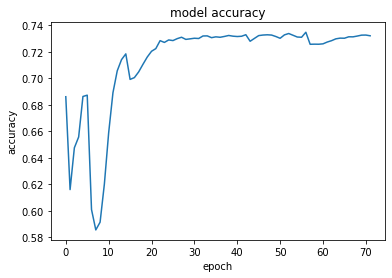

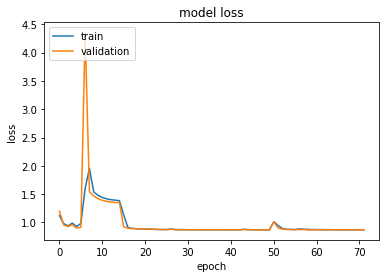

In [15]:
# chart accuracy and loss for train and validation sets

print(modelfit.history.keys())

#  acc
#plt.plot(modelfit.history['accuracy'])
plt.plot(modelfit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Loss
plt.plot(modelfit.history['loss'])
plt.plot(modelfit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

C:\Users\mshaf\anaconda3\envs\jbhi2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


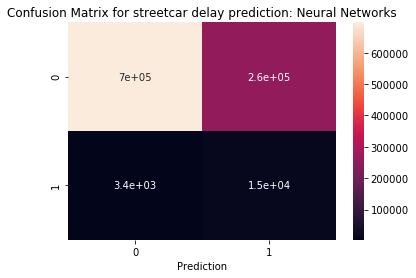

In [42]:

# get rounded predictions
test["predround"] = preds.round().astype(int)
test.predround[:5]

cfmap=metrics.confusion_matrix(y_true=test['target'],  # True labels
                         y_pred=test["predround"])

label = ["0", "1"]
sns.heatmap(cfmap, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction")
plt.title("Confusion Matrix for streetcar delay prediction: Neural Networks")
plt.show()

C:\Users\mshaf\anaconda3\envs\jbhi2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Precision = 0.5255
Recall = 0.7730
Accuracy = 0.7317


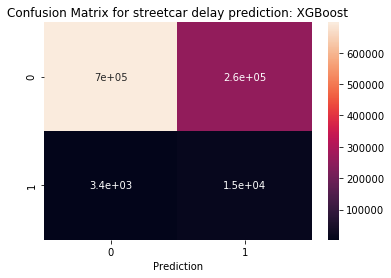

In [50]:
# get rounded predictions
test["predround"] = preds.round().astype(int)

print("Precision = {:.4f}".format(precision_score(test['target'], test["predround"], average='macro')))
print("Recall = {:.4f}".format(recall_score(test['target'], test["predround"], average='macro')))
print("Accuracy = {:.4f}".format(accuracy_score(test['target'], test["predround"])))
cfmap=metrics.confusion_matrix(y_true=test['target'],  # True labels
                         y_pred=test["predround"])

label = ["0", "1"]
sns.heatmap(cfmap, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction")
plt.title("Confusion Matrix for streetcar delay prediction: XGBoost")
plt.show()

#  XGB

In [17]:
# get lists of lists for the training and test datasets
list_of_lists_train = []
list_of_lists_test = []
for i in range(0,7):
    list_of_lists_train.append(X_train_list[i].tolist())
    list_of_lists_test.append(X_test_list[i].tolist())
    

# convert lists of lists to numpy arrays of lists
xgb_X_train = np.array(list_of_lists_train).T
xgb_X_test = np.array(list_of_lists_test).T


In [40]:
%%time
# train XGBoost model using the same balancing factor as used for the deep learning model: one_weight
model_path = get_model_path()
xgb_save_model_path = os.path.join(model_path,'sc_xgbmodel'+modifier+"_"+str(experiment_number)+'.txt')
model = XGBClassifier(scale_pos_weight=one_weight)
model.fit(xgb_X_train, dtrain.target)
model.save_model(xgb_save_model_path)

C:\Users\mshaf\anaconda3\envs\jbhi2\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:24:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 53.3 s


In [19]:
# apply model to the test dataset
y_pred = model.predict(xgb_X_test)
xgb_predictions = [round(value) for value in y_pred]

In [51]:
# evaluate predictions
xgb_accuracy = accuracy_score(test.target, xgb_predictions)
print("Accuracy: %.2f%%" % (xgb_accuracy * 100.0))

y_pred = model.predict(xgb_X_test)
best_preds = [round(value) for value in y_pred]
print("Precision = {:.4f}".format(precision_score(test.target, best_preds, average='macro')))
print("Recall = {:.4f}".format(recall_score(test.target, best_preds, average='macro')))
print("Accuracy = {:.4f}".format(accuracy_score(test.target, best_preds)))

Accuracy: 80.41%
Precision = 0.5387
Recall = 0.8410
Accuracy = 0.8041


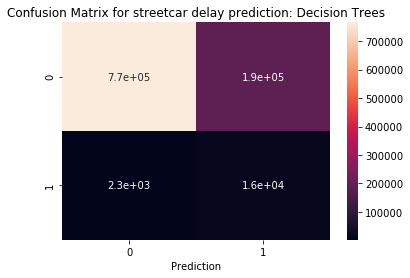

In [53]:
cfmap=metrics.confusion_matrix(y_true=test['target'],  # True labels
                         y_pred=xgb_predictions)

label = ["0", "1"]
sns.heatmap(cfmap, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction")
plt.title("Confusion Matrix for streetcar delay prediction: Decision Trees")
plt.show()

# Decision Tree Classifier

In [45]:

%%time
# get lists of lists for the training and test datasets
list_of_lists_train = []
list_of_lists_test = []
for i in range(0,7):
    list_of_lists_train.append(X_train_list[i].tolist())
    list_of_lists_test.append(X_test_list[i].tolist())
    

# convert lists of lists to numpy arrays of lists
DTC_X_train = np.array(list_of_lists_train).T
DTC_X_test = np.array(list_of_lists_test).T




model_DTC = DecisionTreeClassifier() 
model_DTC.fit(DTC_X_train, dtrain.target)



Wall time: 8.21 s


DecisionTreeClassifier()

In [23]:
# apply model to the test dataset
y_pred = model_DTC.predict(DTC_X_test)
DTC_predictions = [round(value) for value in y_pred]

In [52]:
# evaluate predictions
DTC_accuracy = accuracy_score(test.target, DTC_predictions)
print("Accuracy: %.4f%%" % (DTC_accuracy * 100.0))

y_pred = model.predict(DTC_X_test)

best_preds = [round(value) for value in y_pred]
print("Precision =  {:.4f}".format(precision_score(test.target, DTC_predictions, average='macro')))
print("Recall = {:.4f}".format(recall_score(test.target, DTC_predictions, average='macro')))
print("Accuracy = {:.4f}".format(accuracy_score(test.target, DTC_predictions)))

Accuracy: 96.5974%
Precision =  0.5934
Recall = 0.6198
Accuracy = 0.9660


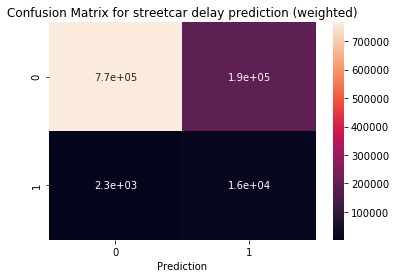

In [25]:
cfmap=metrics.confusion_matrix(y_true=test['target'],  # True labels
                         y_pred=xgb_predictions)

label = ["0", "1"]
sns.heatmap(cfmap, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction")
plt.title("Confusion Matrix for streetcar delay prediction (weighted)")
plt.show()